# **Combinatorial Promoter Example**

written by Andrey Shur, 5/4/2020

Here are some examples for how to use the CombinatorialPromoter part.

The CombinatorialPromoter is supposed to represent the general case where a promoter is transcribable when bound by a specific combination of regulators.

For example, Let's say we have a promoter phrpL which can be bound by the proteins hrpR and hrpS. When both proteins are present, transcription is activated, but when one or the other (or none) is present, transcription is not activated.

In [1]:
#Using Bioscrape: Basic Imports
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
#For arrays and plotting
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
#this is for the network representation
try:
    import bokeh.plotting
    import bokeh.io
    bokeh.io.output_notebook()
    plotCRN = True
except ModuleNotFoundError:
    plotCRN = False
#biocrnpyler
from biocrnpyler import *

Loading BokehJS ...

C:\Users\andrey\Anaconda3\lib\site-packages\bokeh\plotting\graph.py:120: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  warn("Node keys in 'layout_function' don't match node keys in the graph. "


{('phrpL_hrpR', 'cooperativity'): 1.0, ('phrpL_hrpS', 'cooperativity'): 1.0, ('phrpL_hrpR_hrpS_RNAP', 'ktx'): 0.17025, ('phrpL_hrpR_hrpS_RNAP', 'ku'): 11.01321586, ('translation_mm', 'B0030', 'ku'): 10.0, ('translation_mm', 'B0030', 'ktl'): 1.5, ('transcription_mm', 'ktx'): 0.01, ('transcription_mm', 'ku'): 100, 'kb': 1.0, 'ku': 1.0, 'ktx': 2.0, 'ktl': 3.0, 'kdeg': 0.5, 'cooperativity': 2.0}


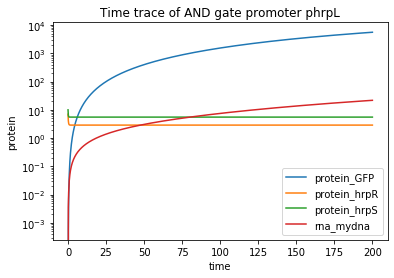

In [2]:
#these are the additional parameters that you need:
parameters = {
    ('phrpL_hrpR', 'cooperativity'): 1.0, #default is 2, but these proteins bind at cooperativity = 1
    ('phrpL_hrpS', 'cooperativity'): 1.0, 
    ('phrpL_hrpR_hrpS_RNAP', 'ktx'): 0.17025,  #this is the transcription rate
    ('phrpL_hrpR_hrpS_RNAP', 'ku'): 11.01321586, #this is the polymerase unbinding rate

    ('translation_mm', 'B0030', 'ku'): 10.0, #Unbinding
    ('translation_mm', 'B0030', 'ktl'): 1.5, #Translation Rate

    ('transcription_mm',  'ktx'): .01,    #These are the parameters for transcription leak
    ('transcription_mm', 'ku'): 100,
    "kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2 #some default parameters
}
#above you can see the desired part_id is very simple. The general syntax is <promoter.name>_<regulator.name>.
#using this syntax you can define the strength of binding of each regulator to the promoter.
#cooperativity between different regulators is not supported.

#you can also define the transcription rate and binding and unbinding (kb or ku) of polymerase from a transcribable
#complex. A transcribable complex is a promoter with regulators bound that is capable of transcription.

#By default, only a promoter with all regulators bound will be capable of transcription. This transcribing promoter
#can be named by writing <promoter.name>_<regulator1.name>_<regulator2.name>_..._RNAP and so forth. Regulators are
#in alphabetical order.

#WARNING!!!
#out of order regulators will not work! For example, phrpL_hrpR_hrpS_RNAP is correct, but phrpL_hrpS_hrpR_RNAP is not.

#now we define the proteins. Their names should match what you put in the promoter, below
hrpR = Protein("hrpR")
hrpS = Protein("hrpS")

#Define the promoter

phrpL = CombinatorialPromoter("phrpL",["hrpR","hrpS"], leak=True) 
#this defines a promoter which binds hrpR and hrpS, and it leaks. 
#By default, leak only happens when there is nothing bound to the DNA.
#this also means that in this promoter, individually bound species (with only one regulator) will not lead tp
#any transcription! This means they will not leak also.

#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL,rbs="B0030",protein="GFP")

#TxTl Extract is a Mixture with more complex internal models
extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS], \
                                     parameters=parameters, parameter_file = "Default Param File Example.tsv")
CRN_extract_1 = extract_1_TXTL.compile_crn()

#below is CRN plotting code. set plotCRN to False to disable
plotCRN = True
if(plotCRN):
    DG, DGspec, DGrxn = generate_networkx_graph(CRN_extract_1)
    plot = Plot(plot_width=500, plot_height=500, x_range=Range1d(-500, 500), y_range=Range1d(-500, 500))
    graphPlot(DG,DGspec,DGrxn,plot)
    bokeh.io.show(plot)

#this is just a normal time trace of the model, with both proteins present
timepoints = np.linspace(0, 200, 1000)
x0 = {"dna_mydna":5.0, "protein_hrpS":10, "protein_hrpR":7, "protein_RNAP":10., "protein_Ribo":50.,}
Re1 = CRN_extract_1.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
plt.plot(timepoints,Re1["protein_GFP"], label = "protein_GFP")
plt.plot(timepoints,Re1["protein_hrpR"], label = "protein_hrpR")
plt.plot(timepoints,Re1["protein_hrpS"], label = "protein_hrpS")
plt.plot(timepoints,Re1["rna_mydna"], label = "rna_mydna")
plt.gca().set_yscale("log")
plt.title("Time trace of AND gate promoter phrpL")
plt.xlabel("time")
plt.ylabel("protein")
plt.legend()
print(parameters)

# Vary hrpR and hrpS
To really test the combinatorial promoter we will vary the concentrations of hrpR and hrpS.

C:\Users\andrey\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


Text(0.5, 1, 'hrpR, hrpS Combinatorial Promoter Heatmap')

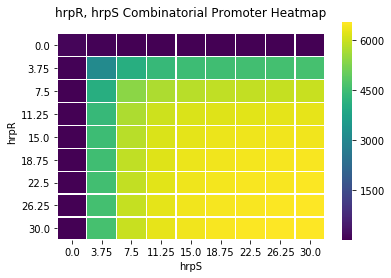

In [61]:
#aggregator data frame
GFP_max = pd.DataFrame(columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])
#Different initial values of R and S
conc_hrpR = np.linspace(0, 30, 9)
conc_hrpS = np.linspace(0, 30, 9)


for conc_R in conc_hrpR:
    x0["protein_hrpR"] = conc_R 
    for conc_S in conc_hrpS:
        x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
        Re1 = CRN_extract_1.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        #now we are simulating over and over again, but only taking the final protein_GFP value
        GFP_max = GFP_max.append({'hrpS_conc':conc_S,
                        'hrpR_conc':conc_R,
                        'GFP_max': Re1["protein_GFP"].values[-1]}, ignore_index=True)

#now, you make a 2d plot with all the data
data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
               columns = 'hrpR_conc',
               values = 'GFP_max')

ax = sns.heatmap(data,
                 cmap = 'viridis',
                linewidths=.2)
ax.set_ylim(9,-0.5) #not sure why this is needed

ax.set(xlabel='hrpS', ylabel='hrpR')
ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")

A couple of things are noted, for example: 
    1) there's not a lot of "off space", before the AND gate turns on.
    2) at 0,0, the expression is slightly higher than at 0,30. This is because the promoter does not express when one out of two promoters are bound, but it does when none of them are (because of leak).

In order to address these points, we can:

    1) increase the unbinding rate
    2) define a transcription rate when one of each regulator is present
    

C:\Users\andrey\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


Text(0.5, 1, 'hrpR, hrpS Combinatorial Promoter Heatmap')

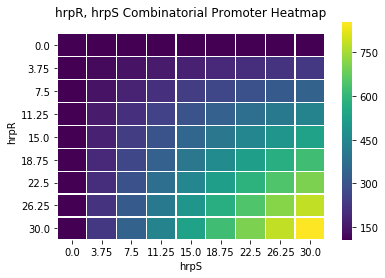

In [63]:
newparam = {
    ('phrpL_hrpR', 'cooperativity'): 1.0, 
    ('phrpL_hrpS', 'cooperativity'): 1.0, 
    ('phrpL_hrpR','ku'):100,
    ('phrpL_hrpS','ku'):100,
    ('phrpL_hrpR_hrpS_RNAP', 'ktx'): 0.17025, 
    ('phrpL_hrpR_hrpS_RNAP', 'ku'): 11.01321586,
    ('phrpL_hrpS_RNAP', 'ku'): 100.,#we'll say that leak has 10x the unbinding rate
    ('phrpL_hrpR_RNAP', 'ku'): 100,
    ('phrpL','ku'):100,
    
}
parameters.update(newparam)
#you can also define the ktx for the leak reaction. I don't think this is necessary
#    ('phrpL_hrpR_RNAP', 'ktx'): 0.17, 
#    ('phrpL_hrpS_RNAP', 'ktx'): 0.17,

phrpL = CombinatorialPromoter("phrpL",["hrpR","hrpS"], 
                              tx_capable_list = [["hrpR","hrpS"],["hrpR"],["hrpS"]],
                              leak=True) 
#now we are saying that there are more species that are capable of transcribing. Specifically, that we 
#can still transcribe when both are bound, but also when one or the other is bound.

#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL,rbs="B0030",protein="GFP")

extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS], \
                                     parameters=parameters, parameter_file = "Perfect Param File Example.tsv")
CRN_extract_1 = extract_1_TXTL.compile_crn()

#aggregator data frame
GFP_max = pd.DataFrame(columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])
#Different initial values of R and S
conc_hrpR = np.linspace(0, 30, 9)
conc_hrpS = np.linspace(0, 30, 9)


for conc_R in conc_hrpR:
    x0["protein_hrpR"] = conc_R 
    for conc_S in conc_hrpS:
        x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
        Re1 = CRN_extract_1.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        #now we are simulating over and over again, but only taking the final protein_GFP value
        GFP_max = GFP_max.append({'hrpS_conc':conc_S,
                        'hrpR_conc':conc_R,
                        'GFP_max': Re1["protein_GFP"].values[-1]}, ignore_index=True)

#now, you make a 2d plot with all the data
data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
               columns = 'hrpR_conc',
               values = 'GFP_max')

ax = sns.heatmap(data,
                 cmap = 'viridis',
                linewidths=.2)
ax.set_ylim(9,-0.5) #not sure why this is needed

ax.set(xlabel='hrpS', ylabel='hrpR')
ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")

If you wanted to make an XOR gate promoter, you could also do it thusly:

C:\Users\andrey\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


Text(0.5, 1, 'hrpR, hrpS Combinatorial Promoter Heatmap')

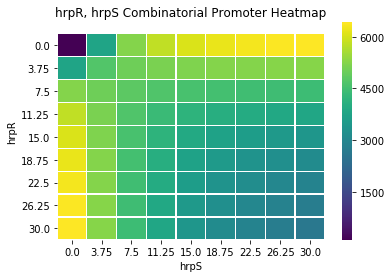

In [65]:
newparam = {
    ('phrpL_hrpR', 'cooperativity'): 1.0, 
    ('phrpL_hrpS', 'cooperativity'): 1.0, 
    ('phrpL_hrpR','ku'):3, #we have to massively decrease the unbinding rate to make this xor gate work
    ('phrpL_hrpS','ku'):3,
    ('phrpL_hrpR_hrpS_RNAP', 'ku'): 100, #this time, this one is leak
    ('phrpL_hrpR_RNAP', 'ktx'): 0.17, #these are now transcribing at high rates!
    ('phrpL_hrpS_RNAP', 'ktx'): 0.17,
    ('phrpL_hrpS_RNAP', 'ku'): 11.,
    ('phrpL_hrpR_RNAP', 'ku'): 11,
    ('phrpL','ku'):100,
    
}

parameters.update(newparam)
phrpL = CombinatorialPromoter("phrpL",["hrpR","hrpS"], 
                              tx_capable_list = [["hrpR"],["hrpS"]],
                              leak=True) 
#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL,rbs="B0030",protein="GFP")

extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS], \
                                     parameters=parameters, parameter_file = "Perfect Param File Example.tsv")
CRN_extract_1 = extract_1_TXTL.compile_crn()

#aggregator data frame
GFP_max = pd.DataFrame(columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])
#Different initial values of R and S
conc_hrpR = np.linspace(0,30, 9)
conc_hrpS = np.linspace(0, 30, 9)
for conc_R in conc_hrpR:
    x0["protein_hrpR"] = conc_R 
    for conc_S in conc_hrpS:
        x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
        Re1 = CRN_extract_1.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        #now we are simulating over and over again, but only taking the final protein_GFP value
        GFP_max = GFP_max.append({'hrpS_conc':conc_S,
                        'hrpR_conc':conc_R,
                        'GFP_max': Re1["protein_GFP"].values[-1]}, ignore_index=True)

#now, you make a 2d plot with all the data
data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
               columns = 'hrpR_conc',
               values = 'GFP_max')

ax = sns.heatmap(data,
                 cmap = 'viridis',
                linewidths=.2)
ax.set_ylim(9,-0.5) #not sure why this is needed

ax.set(xlabel='hrpS', ylabel='hrpR')
ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")